# 03_baseline_models



In [97]:
import os
import math
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import statsmodels.formula.api as sm

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
import logging

# Improve resolution of output graphcis
%config InlineBackend.figure_format ='retina'

In [2]:
file_path = '../data/interim/NYC_capital_projects_3yr.csv'
    
if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [3]:
data = pd.read_csv(file_path)

In [4]:
# entries
print(f"Number of dataset records: {len(data)}")

# num projects
print(f"Number of unique projects in dataset: {len(data['PID'].unique())}")

Number of dataset records: 149
Number of unique projects in dataset: 149


In [5]:
datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data[col] = pd.to_datetime(data[col])

In [6]:
data.info()

data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PID                    149 non-null    int64         
 1   Project_Name           149 non-null    object        
 2   Description            149 non-null    object        
 3   Category               149 non-null    object        
 4   Borough                149 non-null    object        
 5   Managing_Agency        149 non-null    object        
 6   Client_Agency          149 non-null    object        
 7   Phase_Start            149 non-null    object        
 8   Current_Project_Years  149 non-null    float64       
 9   Current_Project_Year   149 non-null    int64         
 10  Design_Start           149 non-null    datetime64[ns]
 11  Budget_Start           149 non-null    float64       
 12  Schedule_Start         149 non-null    datetime64[ns]
 13  Final

,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Phase_Start,Current_Project_Years,Current_Project_Year,...,Schedule_Change,Budget_Change,Schedule_Change_Ratio,Budget_Change_Ratio,Budget_Abs_Per_Error,Budget_Rel_Per_Error,Duration_End_Ratio,Budget_End_Ratio,Duration_Ratio_Inv,Budget_Ratio_Inv
0,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,5.94,6,...,91,"-15,619,967.29",0.04,-0.08,0.09,0.08,1.04,0.92,-0.04,0.09
1,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,2-Design,6.34,7,...,334,"9,618,785.30",0.19,0.18,0.15,0.18,1.19,1.18,-0.16,-0.15
2,91,Mill Basin Bridge Replacement,Complete replacement of bascule bridge with a ...,Bridges,Brooklyn,DOT,not_specified,2-Design,7.44,8,...,247,"-34,672,662.00",0.09,-0.09,0.10,0.09,1.09,0.91,-0.08,0.10


## Inspect projects by category

Can any categories be combined to better balance and reduce the number of categories for one-hot-encoding in the baseline model. 

In [7]:
category_values = data['Category'].value_counts()
category_names = category_values.index

print(category_values)
print('\n')
for name in category_names:
    print(name.upper())
    print()
    for project in data.loc[data['Category']==name]['Project_Name']:
        print(project)
    print('\n')

Streets and Roadways                  31
Sewers                                20
Schools                               15
Industrial Development                15
Water Supply                          13
Wastewater Treatment                  13
Bridges, Streets and Roadways          9
Bridges                                7
Sanitation                             6
Other Government Facilities            4
Public Safety and Criminal Justice     4
Health and Hospitals                   3
Ferries                                3
Arts and Culture                       2
Parks                                  2
Industrial Development, Parks          1
Parks, Streets and Roadways            1
Name: Category, dtype: int64


STREETS AND ROADWAYS

Bergen Avenue Street Reconstruction
Dumbo and Vinegar Hill Area Roadway Reconstruction and Renovation
Edgewood Triangle Roadway Reconstruction
Battery Park Underpass Sandy Flood Damage Repair
Gansevoort Area Roadway Reconstruction
Woodhaven Blvd SBS


In [8]:
magency_values = data['Managing_Agency'].value_counts()
magency_names = magency_values.index

print(magency_values)
print('\n')
for name in magency_names:
    print(name.upper())
    print()
    for project in data.loc[data['Managing_Agency']==name]['Project_Name']:
        print(project)
    print('\n')

DDC     63
DOT     34
DEP     19
SCA     15
EDC     14
DCAS     2
DSNY     2
Name: Managing_Agency, dtype: int64


DDC

Bergen Avenue Street Reconstruction
West 30th Street Trunk Water Main Installations, Phase 2
Pugsley Creek Sewer Relief and Water Main Repair
Queens Water Main New Installations
Dumbo and Vinegar Hill Area Roadway Reconstruction and Renovation
Edgewood Triangle Roadway Reconstruction
West 59th Street Marine Transfer Station Construction, Phase 2
Flatbush Avenue Trunk Watermain Replacement
Fresh Creek Basin Sewers Construction, Phase II
Baisley Boulevard Sewers and Watermain Construction
Fresh Creek Basin Sewers Construction, Phase III
2nd Avenue Watermain Trunk Construction
Francis Lewis Boulevard Construction
Fresh Creek Basin Sewers Construction, Phase I
Gansevoort Area Roadway Reconstruction
Hudson Yards Cultural Shed Facility New Construction
20th Avenue Storm and Sanitary Sewer Construction
Bainbridge Avenue Trunk Water Main
Ped Safety Upgrades on Atlantic Avenue

In [9]:
cagency_values = data['Client_Agency'].value_counts()
cagency_names = cagency_values.index

print(cagency_values)
print('\n')
for name in cagency_names:
    print(name.upper())
    print()
    for project in data.loc[data['Client_Agency']==name]['Project_Name']:
        print(project)
    print('\n')

DEP                    53
not_specified          35
DOT                    17
DOE                    15
DSNY                    7
DCAS                    4
H+H                     3
DPR                     3
DCLA                    2
DOHMH, HHC              1
DOT, Mayor's Office     1
ORR                     1
Mayor's Office          1
EDC                     1
DHS                     1
NYPD                    1
BWS                     1
DEP, EDC                1
DSBS                    1
Name: Client_Agency, dtype: int64


DEP

26th Ward Waste Water Treatment Plant Preliminary Treatment Improvements
Bowery Bay Waste Water Treatment Plant Main Sewage Pump Controls and Piping Replacements
West 30th Street Trunk Water Main Installations, Phase 2
Pugsley Creek Sewer Relief and Water Main Repair
Queens Water Main New Installations
Wards Island Water Pollution Control Plant final Settling Tank Rehabilitation
Hannah Street Pumping Station Construction
Coney Island Biological Nutrient Constru

In [10]:
borough_values = data['Borough'].value_counts()
borough_names = borough_values.index

print(borough_values)
print('\n')
for name in borough_names:
    print(name.upper())
    print()
    for project in data.loc[data['Borough']==name]['Project_Name']:
        print(project)
    print('\n')

not_specified                      47
Brooklyn                           30
Queens                             19
Manhattan                          17
Bronx                              12
Staten Island                       9
Citywide                            5
Valhalla                            2
New York                            2
Brooklyn, Queens                    1
Port Jervis                         1
Olive                               1
Marlboro                            1
Manhattan, Bronx                    1
Manhattan, Staten Island, Bronx     1
Name: Borough, dtype: int64


NOT_SPECIFIED

New Ferry Boat Construction
Woodhaven Blvd SBS
Grand Concourse, Phase 3
Grand Concourse Reconstruction, Phase 4 (Great Streets)
Queens Boulevard Reconstruction (Great Streets)
Hunters Point Street Reconstruction (Long Island City)
Brookville-Edgewood Triangle Reconstruction
FDR Rehabilitation, Northbound (East 42nd to 49th Streets)
Ped Safety Upgrades on Atlantic Avenue, Phase 2
Hen

## Subset and scale data for X and y frames

In [11]:
def scale_features(train_df, val_df, exclude_scale_cols=[], scaler=RobustScaler,
                   scale_before_func=None, scale_after_func=None,
                   reapply_scaler=False, **kwargs):
    """Scales val_df features based on train_df and returns scaled dataframe
    
    Accepts various sklearn scalers and allows you to specify features you do not
    want affected by scaling by using the exclude_scale_cols parameter.
    
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param exclude_scale_cols: Optional list containing names of columns we
                               do not wish to scale, default=[]
    :param scaler: The sklearn scaler method used to fit the data (i.e. StandardScaler,
                    MinMaxScaler, RobustScaler, etc.), default=RobustScaler
    :param scale_before_func: Optional function (i.e. np.log, np.sigmoid, or custom
                              function) to be applied to train and val dfs prior to the
                              scaler fitting and scaling val_df, default=None
    :param scale_after_func: Optional function (i.e. np.log, np.sigmoid, or custom
                             function) to be applied to val_df after the scaler has
                             scaled the datafrme
    :param reapply_scaler: Boolean, if set to True, the scaler is fitted a second time
                           after the scale_after_func is applied (useful if using
                           MinMaxScaler and you wish to maintain a 0 to 1 scale after
                           applying a secondary transformation to the data), default
                           is reapply_scaler=False
    :param kwargs: Any additional arguments are passed as parameters to the selected
                   scaler (for instance feature_range=(-1,1) would be an appropriate
                   argument if scaler is set to MinMaxScaler)
    :return: a feature-scaled version of the val_df dataframe, and a list of fitted
             sklearn scaler objects that were used to scale values (for later use in
             case original values need to be restored), list will either be of length
             1 or 2 depending on whether reapply_scaler was set to True
    """
    # create list of columns to ensure proper ordering of columns for output df
    col_list = list(train_df)
    
    # create list of non-binary column names for scaling
    scaled_columns = train_df.columns.difference(exclude_scale_cols)
    
    # apply initial scaling if specified
    if scale_before_func:
        train_df = scale_before_func(train_df.copy()[scaled_columns])
        val_df = scale_before_func(val_df.copy()[scaled_columns])
        
    # initialize list for storing fitted scaler objects
    Scaler = []
    
    # create Scaler instance fitted on non-binary train data
    Scaler.append(
        scaler(**kwargs).fit(train_df[scaled_columns])
    )
    
    # scale val_df and convert to dataframe with column names
    scaled_train_df = pd.DataFrame(
        Scaler[0].transform(train_df[scaled_columns]),
        columns=scaled_columns,
    )

    scaled_val_df = pd.DataFrame(
        Scaler[0].transform(val_df[scaled_columns]),
        columns=scaled_columns,
    )
    
    # apply initial scaling if specified
    if scale_after_func:
        scaled_train_df = scale_after_func(scaled_train_df.copy())
        scaled_val_df = scale_after_func(scaled_val_df.copy())

    # create StandardScaler instance fitted on non-binary train data
    if reapply_scaler:
        Scaler.append(
            scaler(**kwargs).fit(scaled_train_df[scaled_columns])
        )
        
        scaled_val_df = pd.DataFrame(
            Scaler[1].transform(scaled_val_df[scaled_columns]),
            columns=scaled_columns,
        )
    
    # merge scaled columns with unscaled columns
    scaled_df = pd.concat(
        [
            val_df.drop(scaled_columns, axis=1).reset_index(drop=True),
            scaled_val_df.copy()
        ],
        axis=1,
    )[col_list]
    
    # Return full scaled val dataframe and fitted Scaler object list
    return scaled_val_df, Scaler


def sigmoid(x):
    """Efficient numpy-based sigmoid transformation of a dataframe, array, or matrix
    
    :param x: data to undergo transformation (datatypes accepted include,
              pandas DataFrames and Series, numpy matrices and arrays, or single
              int or float values x)
    :return: The transformed dataframe, series, array, or value depending on
             the type of original input x object
    """
    return 1/(1 + np.exp(-x)) 


def log_plus_one(x):
    """Adds 1 to the input data and then applies Log transformation to those values
    
    :param x: data to undergo transformation (datatypes accepted include,
              pandas DataFrames and Series, numpy matrices and arrays, or single
              int or float values x)
    :return: The transformed dataframe, series, array, or value depending on
             the type of original input x object
    """
    return np.log(x + 1)

In [12]:
X_cols = [
    'Budget_Start',
    'Duration_Start',
]

y_cols = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]


In [13]:
X, y = data[X_cols], data[y_cols]

In [14]:
random_state = 0
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

In [15]:
print('{}\t{}'.format(X_train.shape, y_train.shape))
print('{}\t\t{}'.format(X_test.shape, y_test.shape))

(134, 2)	(134, 2)
(15, 2)		(15, 2)


In [16]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify columns to exclude from scaling (i.e. binary and non-predictor columns)
exclude_scale_cols = []

# Perform standard scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None

X_train_stdz, Scaler_stdz = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_stdz, Scaler_stdz = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

# Perform standard scaling and then pass through sigmoid transformation
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid

X_train_stdz_sig, _ = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_stdz_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)


# Perform normalized scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = MinMaxScaler
scale_before_func = None
scale_after_func = None

X_train_norm, Scaler_norm = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_norm, Scaler_norm = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)


# Perform normalized scaling then add 1 and perform log transformation and renormalize
scaler = MinMaxScaler
scale_before_func = None
scale_after_func = log_plus_one
reapply_scaler = True

X_train_norm_log, _ = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_norm_log, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Perform 'Robust' scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = RobustScaler
scale_before_func = None
scale_after_func = None

X_train_rob, Scaler_rob = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)

X_test_rob, Scaler_rob = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
)



In [17]:
X_train_norm_log.describe()

,Budget_Start,Duration_Start
count,134.00,134.00
mean,0.07,0.42
std,0.12,0.18
min,0.00,0.00
25%,0.02,0.30
50%,0.04,0.41
75%,0.06,0.51
max,1.00,1.00


In [18]:
X_train_rob.describe()

,Budget_Start,Duration_Start
count,134.00,134.00
mean,1.20,0.08
std,4.89,0.86
min,-1.15,-1.65
25%,-0.40,-0.53
50%,0.00,0.00
75%,0.60,0.47
max,42.73,3.31


In [40]:
type(2.4) in (pd.core.series.Series, pd.core.frame.DataFrame)

False

In [39]:
type(y_train) in (pd.core.series.Series, pd.core.frame.DataFrame)

True

In [38]:
type(y_train['Budget_Change_Ratio']) in (pd.core.series.Series, pd.core.frame.DataFrame)

True

## Define functions for fitting and evaluating models

In [244]:
# def score_outputs(y_train, y_test, pred_train, pred_test):
#     """Returns R2 scores for train and test predictions
    
#     This function will work for either single- or multi-output predictions
#     and accepts either pandas Series or DataFrame or numpy array objects as
#     inputs
    
#     :return: tuple containing 2 lists of R2 scores, one list for train
#              and one list for test scores. Each list contains a score
#              for each feature predicted (i.e. budget and duration) if
#              multi-output prediction was used, or a single score if
#              single-output prediction was used
#     """
#     if type(y_train) in (pd.core.series.Series, pd.core.frame.DataFrame):
#         y_train = y_train.values
        
#     if type(y_test) in (pd.core.series.Series, pd.core.frame.DataFrame):
#         y_test = y_test.values
        
#     score_train = [
#         r2_score(true, pred) for true, pred in zip(y_train.T, pred_train.T)
#     ]
#     score_test = [
#         r2_score(true, pred) for true, pred in zip(y_test.T, pred_test.T)
#     ]
    
#     return score_train, score_test


def generate_model_dict(model, model_descr, X_train, X_test, y_train, y_test,
                        multioutput=True, verbose=False, predictions=True,
                        scores=True, model_api='sklearn', sm_formula=None,
                        y_stored=True, **kwargs):
    """Fits the specified model type and generates a dictionary of results
    
    This function works for fitting and generating predictions for 
    sklearn, keras, and statsmodels models. PyGam models typically also
    work by specifying the 'sklearn' model_api. For statsmodels models, only those
    that depend on the statsmodels.formula.api work.
    
    :param model: the uninitialized sklearn, pygam, or statsmodels regression
                  model object, or a previously compiled keras model
    :param model_descr: a brief string describing the model (cannot exceed 80
                        characters)  
    :param X_train, X_test, y_train, y_test: the datasets on which to fit and
                                             evaluate the model
    :param multioutput: Boolean, if True and sklearn model_api, will attempt
                        fitting a single multioutput model, if False or 'statsmodel'
                        model_api fits separate models for each output
    :param verbose: if True, prints resulting fitted model object (default=False)
    :param predictions: if True the dict stores model.predict() predictions for
                        both the X_train and X_test input dataframes
    :param scores: if True, metrics scores are calculated and stored in the
                   resulting dict for both the train and test predictions
    :param model_api: specifies the api-type required for the input model, options
                      include 'sklearn', 'keras', or 'statsmodels' (default='sklearn')
    :param sm_formula: statsmodels formula defining model (include only endogenous
                       variables, such as 'x1 + x2 + x3' instead of 'y ~ x1 + x2 + 
                       x3'), default is None
    :param y_stored: boolean, determines whether the true y values are stored in the
                     resulting dictionary. It is convenient to keep these stored
                     alongside the predictions for easier evaluation later (default
                     is y_stored=True)
    :param **kwargs: are optional arguments that pass directly to the model object
                     at time of initialization, or in the case of the 'keras' model
                     api, they pass to the keras.mdoel.fit() method

    :return: returns a dictionary object containing the resulting fitted model
             object, resulting predictions, and train and test scores (if specified
             as True)
    """
    # check description len
    max_model_descr = 80
    len_model_descr = len(model_descr) 
    if len_model_descr > max_model_descr:
        raise ValueError(
            'Model description is currently {}, but cannot exceed {} characters'\
            ''.format(len_model_descr, max_model_descr)
        )
    # check that valid model_api was entered
    if model_api not in ['sklearn', 'keras', 'statsmodels']:
        raise ValueError(
            "model_api only accepts 'sklearn', 'keras', or 'statsmodels', "\
            "but you have entered: {}".format(model_api)
        )
    
    # initialize fit model list
    FitModel = []
    
    # initialize formula to store when statsmodels
    formulas = []
    
    # store exogen
    y_variables = list(y_train.columns)
    
    # Fit model with parameters specified by kwargs
    if model_api=='sklearn' and multioutput:
        FitModel.append(model(**kwargs).fit(X_train, y_train))
    
    if model_api=='sklearn' and not multioutput:
        for col in y_variables:
            FitModel.append(model(**kwargs).fit(X_train, y_train[col]))
            
    # Note that the **kwargs are passed to the .fit() method in the keras api
    # Keras models must be defined and compiled prior to passing to this function
    if model_api=='keras':
        FitModel.append(model.fit(X_train, y_train, **kwargs))

    # statsmodel fit using statsmodels.formula.api, so need to record
    # resulting formulas for use while fitting and in final dict
    if model_api=='statsmodels':
        for i, y in enumerate(y_variables):
            formulas.append(y + ' ~ {}'.format(sm_formula))
            FitModel.append(
                model(
                    formula=formulas[i],
                    data=X_train.join(y_train[y])
                ).fit()
            )

    # generate and save predictions on both train and test data
    if model_api=='statsmodels' or not multioutput:
        train_pred = np.hstack([
            np.array(model.predict(X_train)).reshape(-1,1)
            for model in FitModel
        ])
            
        test_pred = np.hstack([
            np.array(model.predict(X_test)).reshape(-1,1)
            for model in FitModel
        ])
        
    else:
        train_pred = FitModel[0].predict(X_train)
        test_pred = FitModel[0].predict(X_test)
    
    # store fitted model, predictions and scores to dict 
    model_dict = {
        'description': model_descr
    }
    
    model_dict['model'] = FitModel
    model_dict['y_variables'] = y_variables
    model_dict['formulas'] = formulas
    
    if y_stored:
        model_dict['y_values'] = {
            'train': y_train,
            'test': y_test,
        }
        
    if predictions:
        model_dict['predictions'] = {
            'train': train_pred,
            'test': test_pred,
        }
    
    if scores:
        model_dict['score'] = {
            'train': r2_score(y_train, train_pred, multioutput='raw_values'),
            'test': r2_score(y_test, test_pred, multioutput='raw_values'),
        }
    
    if verbose:
        print("\t{}".format(FitModel))

    return model_dict


def print_model_results(model_dict, score='both'):
    """
    Prints a model results summary from the model dictionary generated
    using the generate_model_dict() function
    
    :param model_dict: dict, output dictionary from the generate_model_dict()
                       function
    :param accuracy: None, 'both', 'test', or 'train' parameters accepted,
              identifies which results to print for this particular metric
              
    :return: nothing is returned, this function just prints summary output
    """
    train_opt = ['train', 'both']
    test_opt = ['test', 'both']
    
    print(
        '\nMODEL SUMMARY:\n{}\n\n\nThe fitted model object(s):\n'.format(
            model_dict['description']
        )
    )
    
    for model in model_dict['model']:
          print('\t{}\n'.format(model))
    
    if ('formulas' in model_dict.keys()) and len(model_dict['formulas']):
        print("\nThe formula for each fitted model object:\n")
        for formula in model_dict['formulas']:
            print('\t{}\n'.format(formula))
    
    if score:
        print('\nThis model resulted in the following R-squared scores:\n')
        for i, var in enumerate(model_dict['y_variables']):
            print('\t{}\n'.format(var))
            if score in train_opt:
                print('\t\tTraining\t{:.4f}'.format(model_dict['score']['train'][i]))
            if score in test_opt:
                print('\t\tTest\t\t{:.4f}'.format(model_dict['score']['test'][i]))
            print()
        print('\n')
            

In [238]:
sm_formula = 'Budget_Start + Duration_Start'
model_descr = 'Linear regression with unscaled data'

print_model_results(generate_model_dict(sm.ols, model_descr, X_train, X_test, y_train, y_test,
                           multioutput=True, verbose=False,
                           predictions=True, scores=True, model_api='statsmodels',
                           sm_formula=sm_formula))


MODEL SUMMARY:
Linear regression with unscaled data


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0045
		Test		-1.2832

	Schedule_Change_Ratio

		Training	0.1997
		Test		0.2920





In [245]:
model_dict_test = generate_model_dict(LinearRegression, model_descr, X_train, X_test, y_train, y_test,
                    multioutput=True, verbose=False,
                    predictions=True, scores=True, model_api='sklearn')

print_model_results(model_dict_test)


MODEL SUMMARY:
Linear regression with unscaled data


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0045
		Test		-1.2832

	Schedule_Change_Ratio

		Training	0.1997
		Test		0.2920





In [53]:
LinReg = LinearRegression()
LinReg.fit(X_train_stdz, y_train['Budget_Change_Ratio'])
pred_train = LinReg.predict(X_train_stdz)
pred_test = LinReg.predict(X_test_stdz)
score_train = r2_score(y_train['Budget_Change_Ratio'], pred_train)
score_test = r2_score(y_test['Budget_Change_Ratio'], pred_test)

In [56]:
r2_score(y_test['Budget_Change_Ratio'], pred_test, multioutput='raw_values')

array([-1.28316345])

In [67]:
pred_train

array([ 1.15837837,  1.19232798, -1.10745026,  1.17827425,  1.28594317,
        1.23520701,  1.11342323,  1.27581056,  1.2760237 ,  1.21741607,
        1.14742784,  1.27781391,  1.25875379,  1.26484162,  1.14229371,
        1.26283918,  1.14374607,  1.23580102,  1.30485155,  1.25345368,
        1.24461975,  1.09316996,  1.22322013,  0.97691769,  0.5094731 ,
        1.17438075,  1.18336629,  1.1742602 ,  1.24176753,  1.2527487 ,
        1.12479946,  1.22785362,  1.29298269,  1.16621087,  1.26573532,
        1.24383083,  1.33675527,  1.1795697 ,  1.17652461,  1.3034071 ,
        0.2316641 ,  1.17573077,  0.99700171,  1.28338485,  1.28330056,
        1.22604382,  1.07296524,  1.03231573,  1.26848012,  1.26030291,
        0.89397009,  1.29450736,  1.2350985 ,  1.17263491,  1.19398399,
        1.19702615,  1.27203535,  0.76078189,  1.03303475,  1.12773081,
        1.21889503,  0.5286687 ,  1.1215176 ,  1.12394207,  1.24046321,
        1.23290645,  1.21107862,  1.17791776,  1.2486968 ,  1.28

In [33]:
score_outputs(y_train, y_test, pred_train, pred_test)

([0.004531602127580192, 0.19972539548896884],
 [-1.2831634530393887, 0.2919510153145105])

In [30]:
type(None)

NoneType

## Define plotting functions to inspect scaled input data and regression results

In [287]:
def plot_budget_schedule(X, X_scaled, scale_descr, X_test=None, X_test_scaled=None):
    """Plots original vs scaled versions of budget and schedule input data
    
    :param X: Dataframe or 2D array with original budget and schedule train data
    :param X_scaled: Dataframe or 2D array with scaled budget and schedule train data
    :param scale_descr: Short string description of scaling transformation used
                        to title scaled data plot (e.g. 'Sigmoid Standardized')
    :param X_test: Optional, Dataframe or 2D array with original test data, which
                   will plot test data as overlay with training data (default is
                   X_test=None, which does not plot any overlay)
    :param X_test_scaled: Optional, Dataframe or 2D array with original test data,
                          which plots overlay similar to X_test (default is
                          X_test_scaled=None)
                          
    :return: Generates 1x2 subplotted scatterplots, no objects returned
    """
    corr = np.corrcoef(X.T)[0, 1]
    corr_scaled = np.corrcoef(X_scaled.T)[0, 1]

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    
    plt.suptitle(
        'Original budget and duration values vs. {} scaled values'.format(scale_descr),
        y=1.05,
        fontsize=18
    )
    
    for i, (data, data_test) in enumerate(zip([X, X_scaled], [X_test, X_test_scaled])):
        ax[i].scatter(
            *data.values.T,
            color='k',
            alpha=0.5,
            edgecolor='w',
            s=80,
            label='training obs'
        )
        ax[i].set_title(
            'Original data\n({:.2f} pearson coefficient)'.format(corr) if i==0
            else '{} scaled\n({:.2f} pearson coefficient)'.format(scale_descr, corr_scaled),
            fontsize=14
        )
        ax[i].set_xlabel('Budget', fontsize=12)
        if i==0:
            ax[i].set_ylabel('Duration (days)', fontsize=12)

        if type(X_test)!='NoneType':
            ax[i].scatter(
                *data_test.values.T,
                color='tab:orange',
                alpha=1,
                edgecolor='w',
                marker='s',
                s=80,
                label='test obs'
            )
        
        ax[i].grid(':', alpha=0.4)
        
    ax[0].legend(fontsize=12, edgecolor='k', loc=4)        
    plt.tight_layout()
    plt.show();
    
    
def plot_true_pred(model_dict=None, dataset='train', y_true=None, y_pred=None,
                   model_descr=None, y1_label=None, y2_label=None):
    """Plots model prediction results directly from model_dict or input arrays
    
    This plotting function only really requires that a model_dict from the
    generate_model_dict() function be used as input. However, through use of
    the y_true, y_pred, model_descr, and y1 and y2 label parameters, predictions
    stored in a shape (n,2) array can be plotted directly wihtout the use of
    a model_dict
    
    NOTE: This plotting function requires y to consist of 2 output variables.
          Therefore, it will not work with y data not of shape=(n, 2).
    
    :param model_dict: dictionary or None, if model results from the
                       generate_model_dict func is used, function defaults to
                       data from that dict for plot, if None plot expects y_true,
                       y_pred, model_descr, and y1/y2 label inputs for plotting
    :param test: boolean, indicates whether to plot training or test results
                 if using model_dict as data source, and labels plots accordingly
                 if y_pred and y_true inputs are used
    :param y_true, y_pred: None or pd.DataFrame and np.array shape=(n,2) data sources
                           accepted and used for plotting if model_dict=None
                           (default for both is None)
    :param model_descr: None or string of max length 80 used to describe model in
                        title. If None, model_descr defaults to description in
                        model_dict, if string is entered, that string overrides the
                        description in model_dict, if using y_true/y_test as data
                        source model_descr must be specified as a string (default
                        is None)
    :param y1_label, y2_label: None or string of max length 40 used to describe
                               the 2 output y variables being plotted. These values
                               appear along the plot axes and in the titles of
                               subplots. If None, the y_variables names from the
                               model_dict are used. If strings are entered, those
                               strings are used to override the model_dict values.
                               If using y_true/y_test as data source, these values
                               must be specified (default is None for both label)
    :return: Generates 5 subplots, (1) true values with predicted values overlay, 
             each y variable on its own axis, (2) output variable 1 true vs. predicted
             on each axis,(3) output variable 2 true vs. predicted on each axis
             (4) output variable 1 true vs. residuals, (5) output variable 2 true
             vs. residuals (no objects are returned)
    """        
    # create placeholder var_labels list for easier handling of conditionals
    var_labels = [None, None]

    # extract required objects from model_dict if not None 
    if type(model_dict)==dict:
        y_true = model_dict['y_values'][dataset]
        y_pred = model_dict['predictions'][dataset]
        r2_scores = model_dict['score'][dataset]
        var_labels = [
            var.replace('_', ' ') for var in model_dict['y_variables']
        ]
        
        if model_descr==None:
            model_descr = model_dict['description']
    # calculate r2 scores if model_dict not provided
    else:
        r2_scores = r2_score(y_true, y_pred, multioutput='raw_values')
        
    # Set y labels or overwrite y labels if specified as not None
    if y1_label != None:
        var_labels[0] = y1_label
    if y2_label != None:
        var_labels[1] = y2_label

    # if y inputs are pandas dataframes, convert to numpy array
    if type(y_true)==pd.core.frame.DataFrame:
        y_true = y_true.copy().values        
    if type(y_pred)==pd.core.frame.DataFrame:
        y_pred = y_pred.copy().values
        
    # GENERATE PLOT 1
    fig, ax = plt.subplots(figsize=(12,6))
    
    plt.title(
        '{} predictions vs. true values for\n{}\n'.format(
            'TEST' if dataset.lower()=='test' else 'TRAINING', model_descr
        ),
        fontsize=18
    )
 
    plt.scatter(
        *y_true.T,
        color='silver',
        alpha=1,
        edgecolor='gray',
        marker='s',
        s=90,
        label='True values'
    )
    plt.scatter(
        *y_pred.T,
        color='c',
        alpha=1,
        edgecolor='k',
        marker='o',
        s=90,
        label='Predicted values'
    )
    
    ax.set_xlabel(var_labels[0], fontsize=12)
    ax.set_ylabel(var_labels[1], fontsize=12)

    ax.legend(fontsize=12, edgecolor='k')
            
    ax.grid(':', alpha=0.4)
    plt.tight_layout()
    plt.show()

    # GENERATE SUBPLOTS 2 AND 3
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    
    plt.suptitle(
        'Predictions and residuals vs. true values by output variable',
        y=1.05,
        fontsize=16
    )
    
    for i, (ax, true, pred) in enumerate(zip(axes.flat, y_true.T, y_pred.T)):
        ax.scatter(
            true, pred,
            color='k',
            alpha=0.5,
            edgecolor='w',
            s=90
        )
        ax.set_title(
            '{}\n$R^2={:.3f}$'.format(var_labels[i], r2_scores[i]),
            fontsize=14
        )
        ax.set_xlabel('True value', fontsize=12)
        if i==0:
            ax.set_ylabel('Predicted value', fontsize=12)
        ax.axis('equal')
        ax.grid(':', alpha=0.4)
        
    plt.tight_layout()
    plt.show()

    # GENERATE SUBPLOTS 4 AND 5
    fig, axes = plt.subplots(1, 2, figsize=(12,3))
        
    for i, (ax, true, pred) in enumerate(zip(axes.flat, y_true.T, y_pred.T)):        
        ax.scatter(
            true, pred-true,
            color='k',
            alpha=0.5,
            edgecolor='w',
            s=90
        )
        ax.axhline(0, color='k', linestyle='--')
        ax.set_title('Residuals', fontsize=14)        
        ax.set_xlabel('True value', fontsize=12)
        if i==0:
            ax.set_ylabel('Prediction error', fontsize=12)
        ax.grid(':', alpha=0.4)

    plt.tight_layout()
    plt.show()

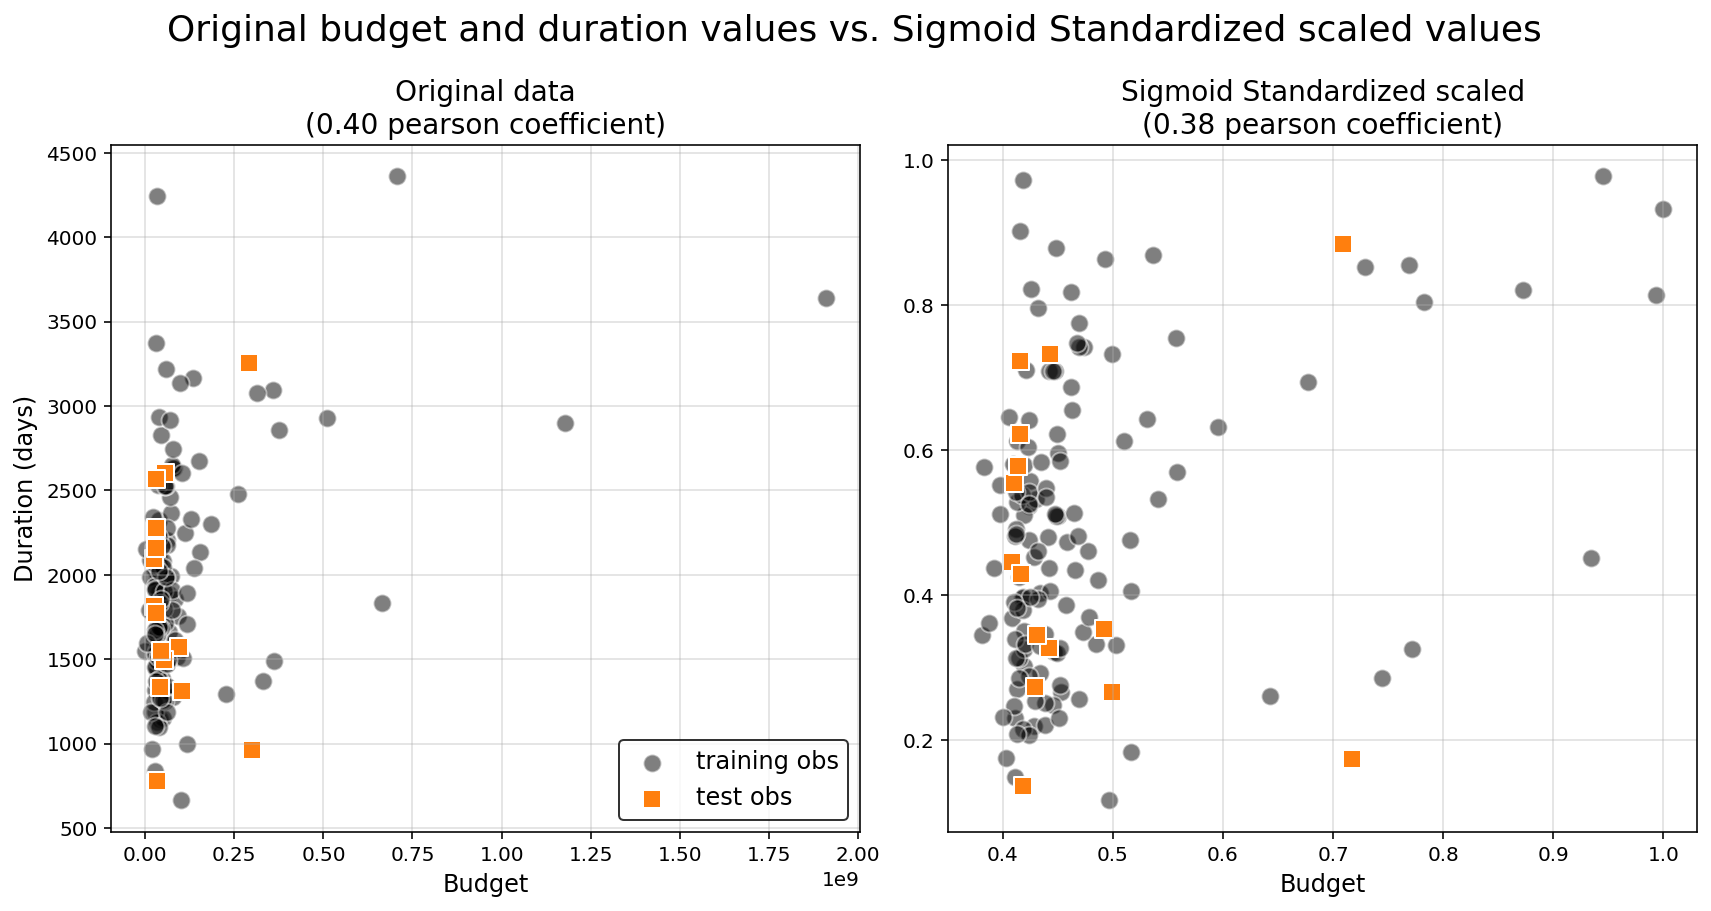

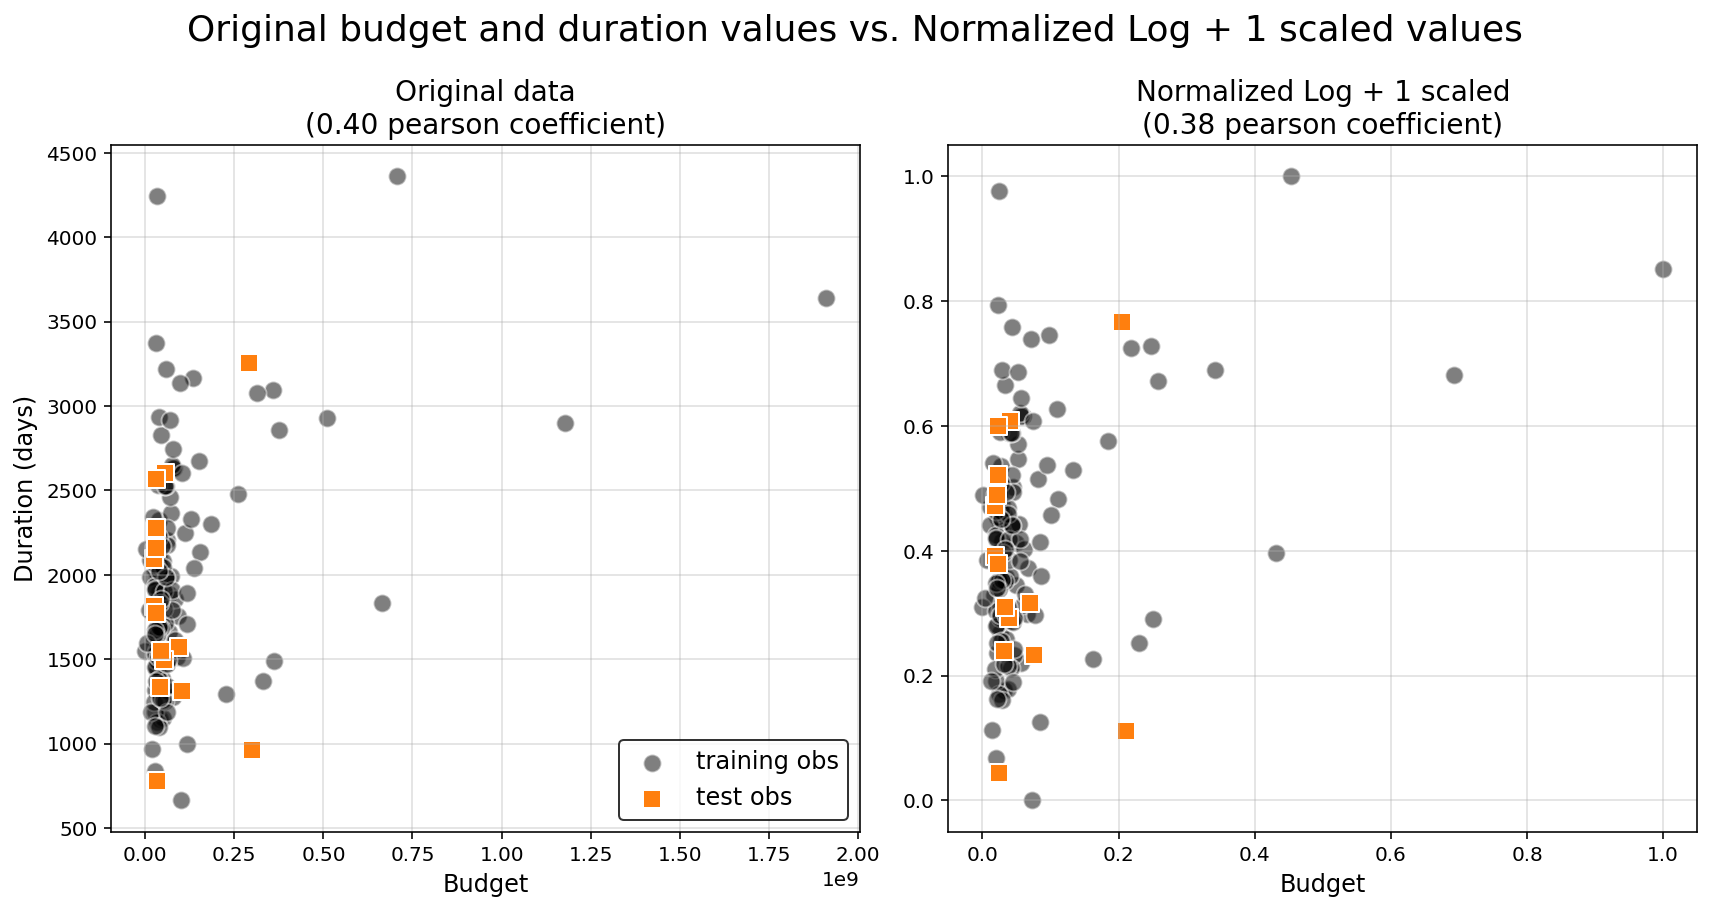

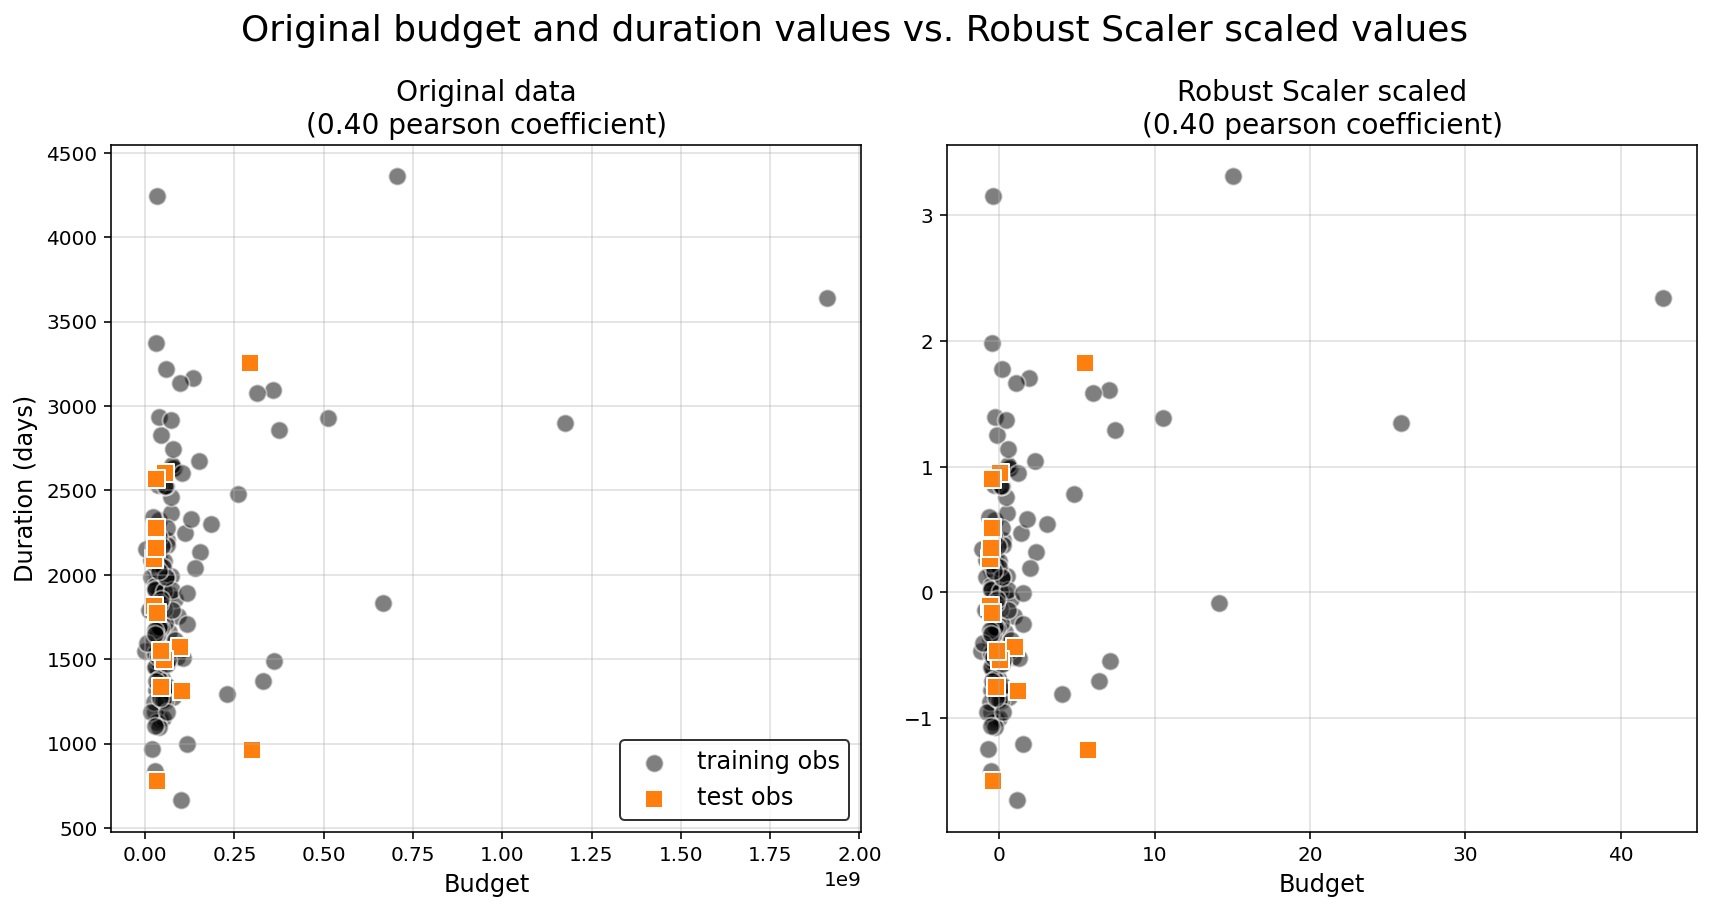

In [213]:
plot_budget_schedule(X_train, X_train_stdz_sig, 'Sigmoid Standardized', X_test, X_test_stdz_sig)
plot_budget_schedule(X_train, X_train_norm_log, 'Normalized Log + 1', X_test, X_test_norm_log)
plot_budget_schedule(X_train, X_train_rob, 'Robust Scaler', X_test, X_test_rob)

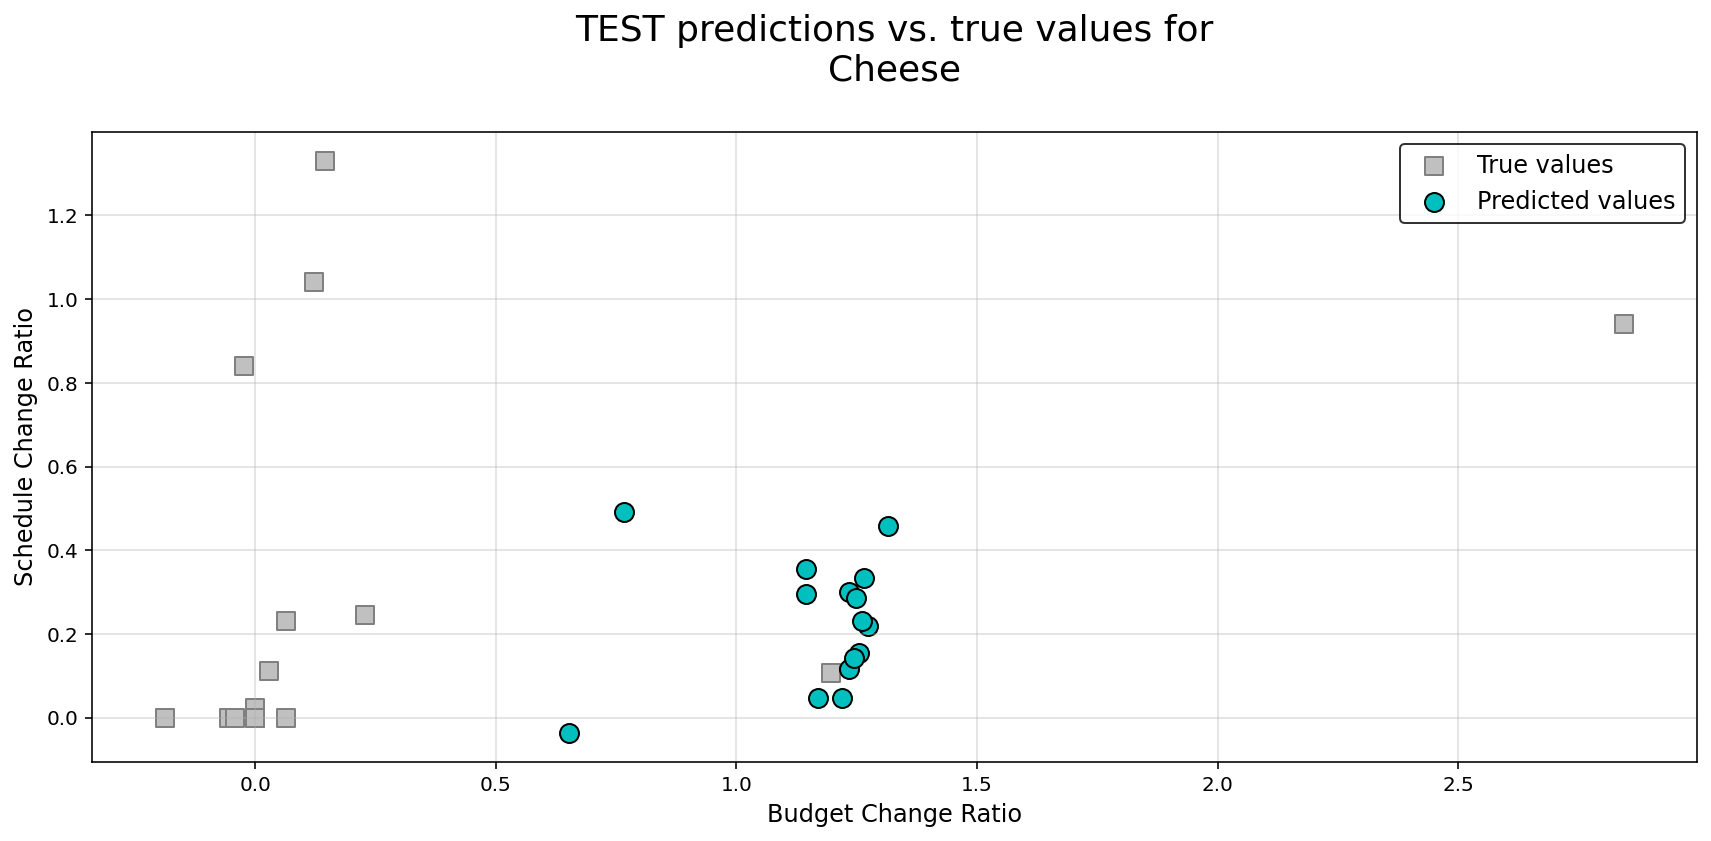

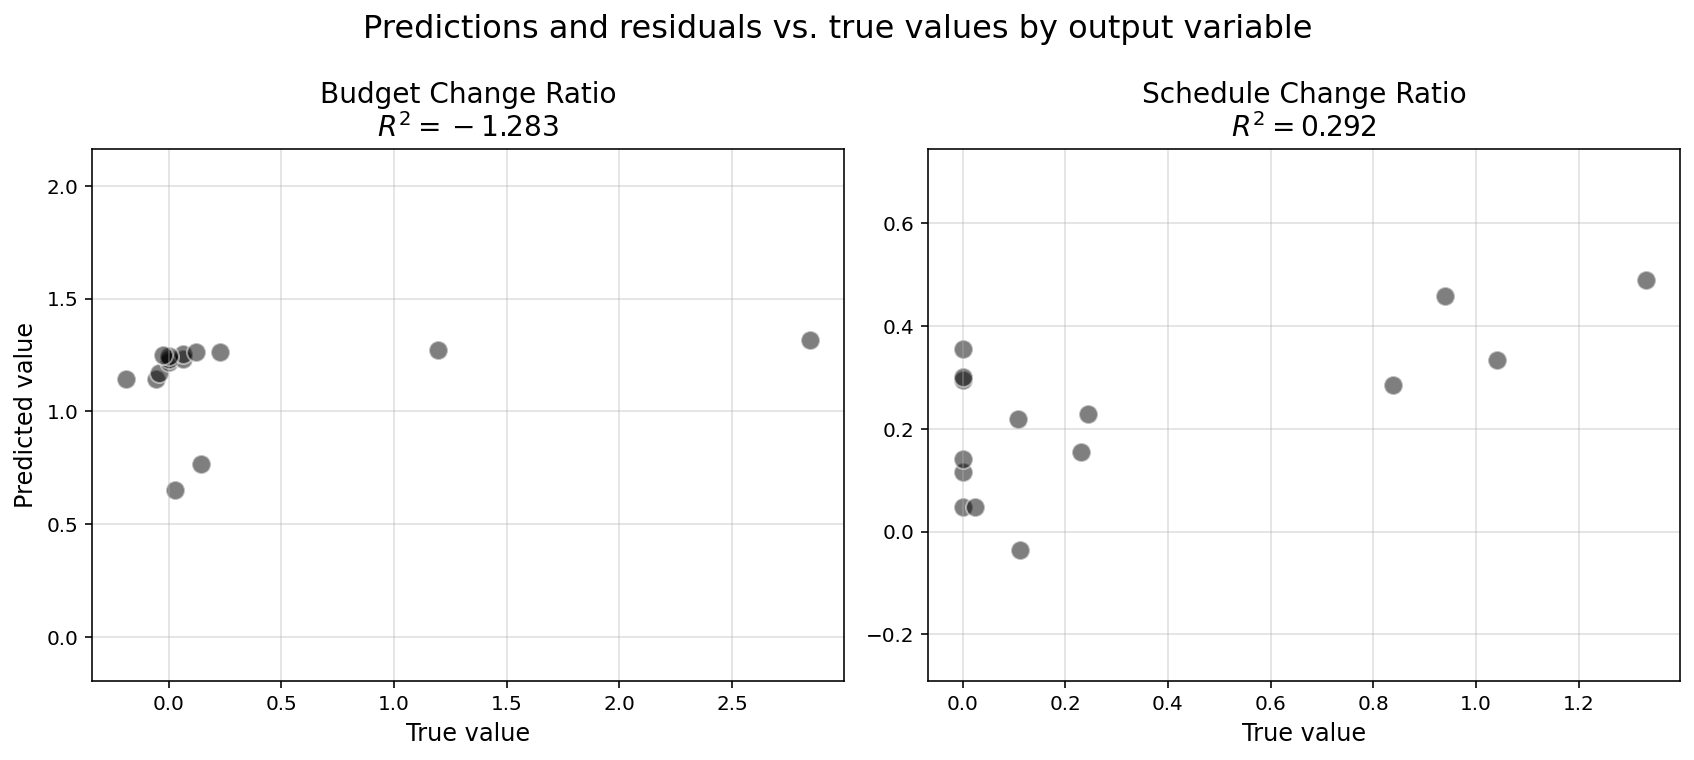

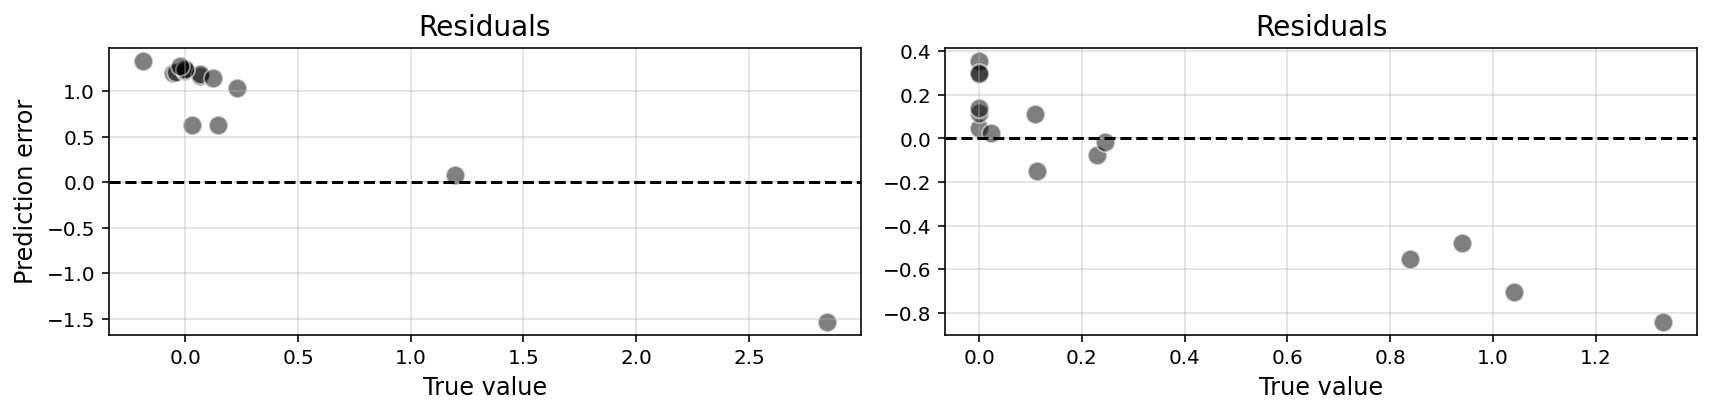

In [291]:
model_descr = 'linear regression with normalized log+1 data linear regression with normalized'
plot_true_pred(model_dict=model_dict_test, dataset='test', model_descr='Cheese')